In [7]:
import os

def find_folders_with_string(path, search_string):
    matching_folders = []
    for root, dirs, files in os.walk(path):  # Walk through the directory tree
        for folder_name in dirs:
            if search_string in folder_name:  # Check if the string is in the folder name
                return os.path.join(root, folder_name)

# Example usage
path_to_search = "../results"
string_to_find = "circle-H_transformer"
folders = find_folders_with_string(path_to_search, string_to_find)

import sys
sys.path.append("../")

from src.utils.visualization import visualize_best_embedding, get_right_and_left_coset

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

data_size = 1000
train_ratio = 0.8

data_id_choices = ["lattice", "circle", "family_tree", "permutation", "equivalence"]
model_id_choices = ["standard_MLP","H_MLP", "standard_transformer","H_transformer"]

colors = ['r', 'g', 'b', 'y', 'm', 'c', 'k', 'w']

seed_list = np.linspace(0, 1000, 20, dtype=int)


data_id_to_title_map = {
    'lattice': 'In-Context Learning',
    'family_tree': 'Genealogy Learning',
    'equivalence': 'Equivalence Classes',
    'circle': 'Modular Addition',
    'permutation' : 'Permutation Groups'
}

model_id_to_legend_map = {
    'standard_MLP': 'Standard MLP',
    'H_MLP': 'Harmonic MLP',
    'standard_transformer': 'Standard Transformer',
    'H_transformer': 'Harmonic Transformer'
}

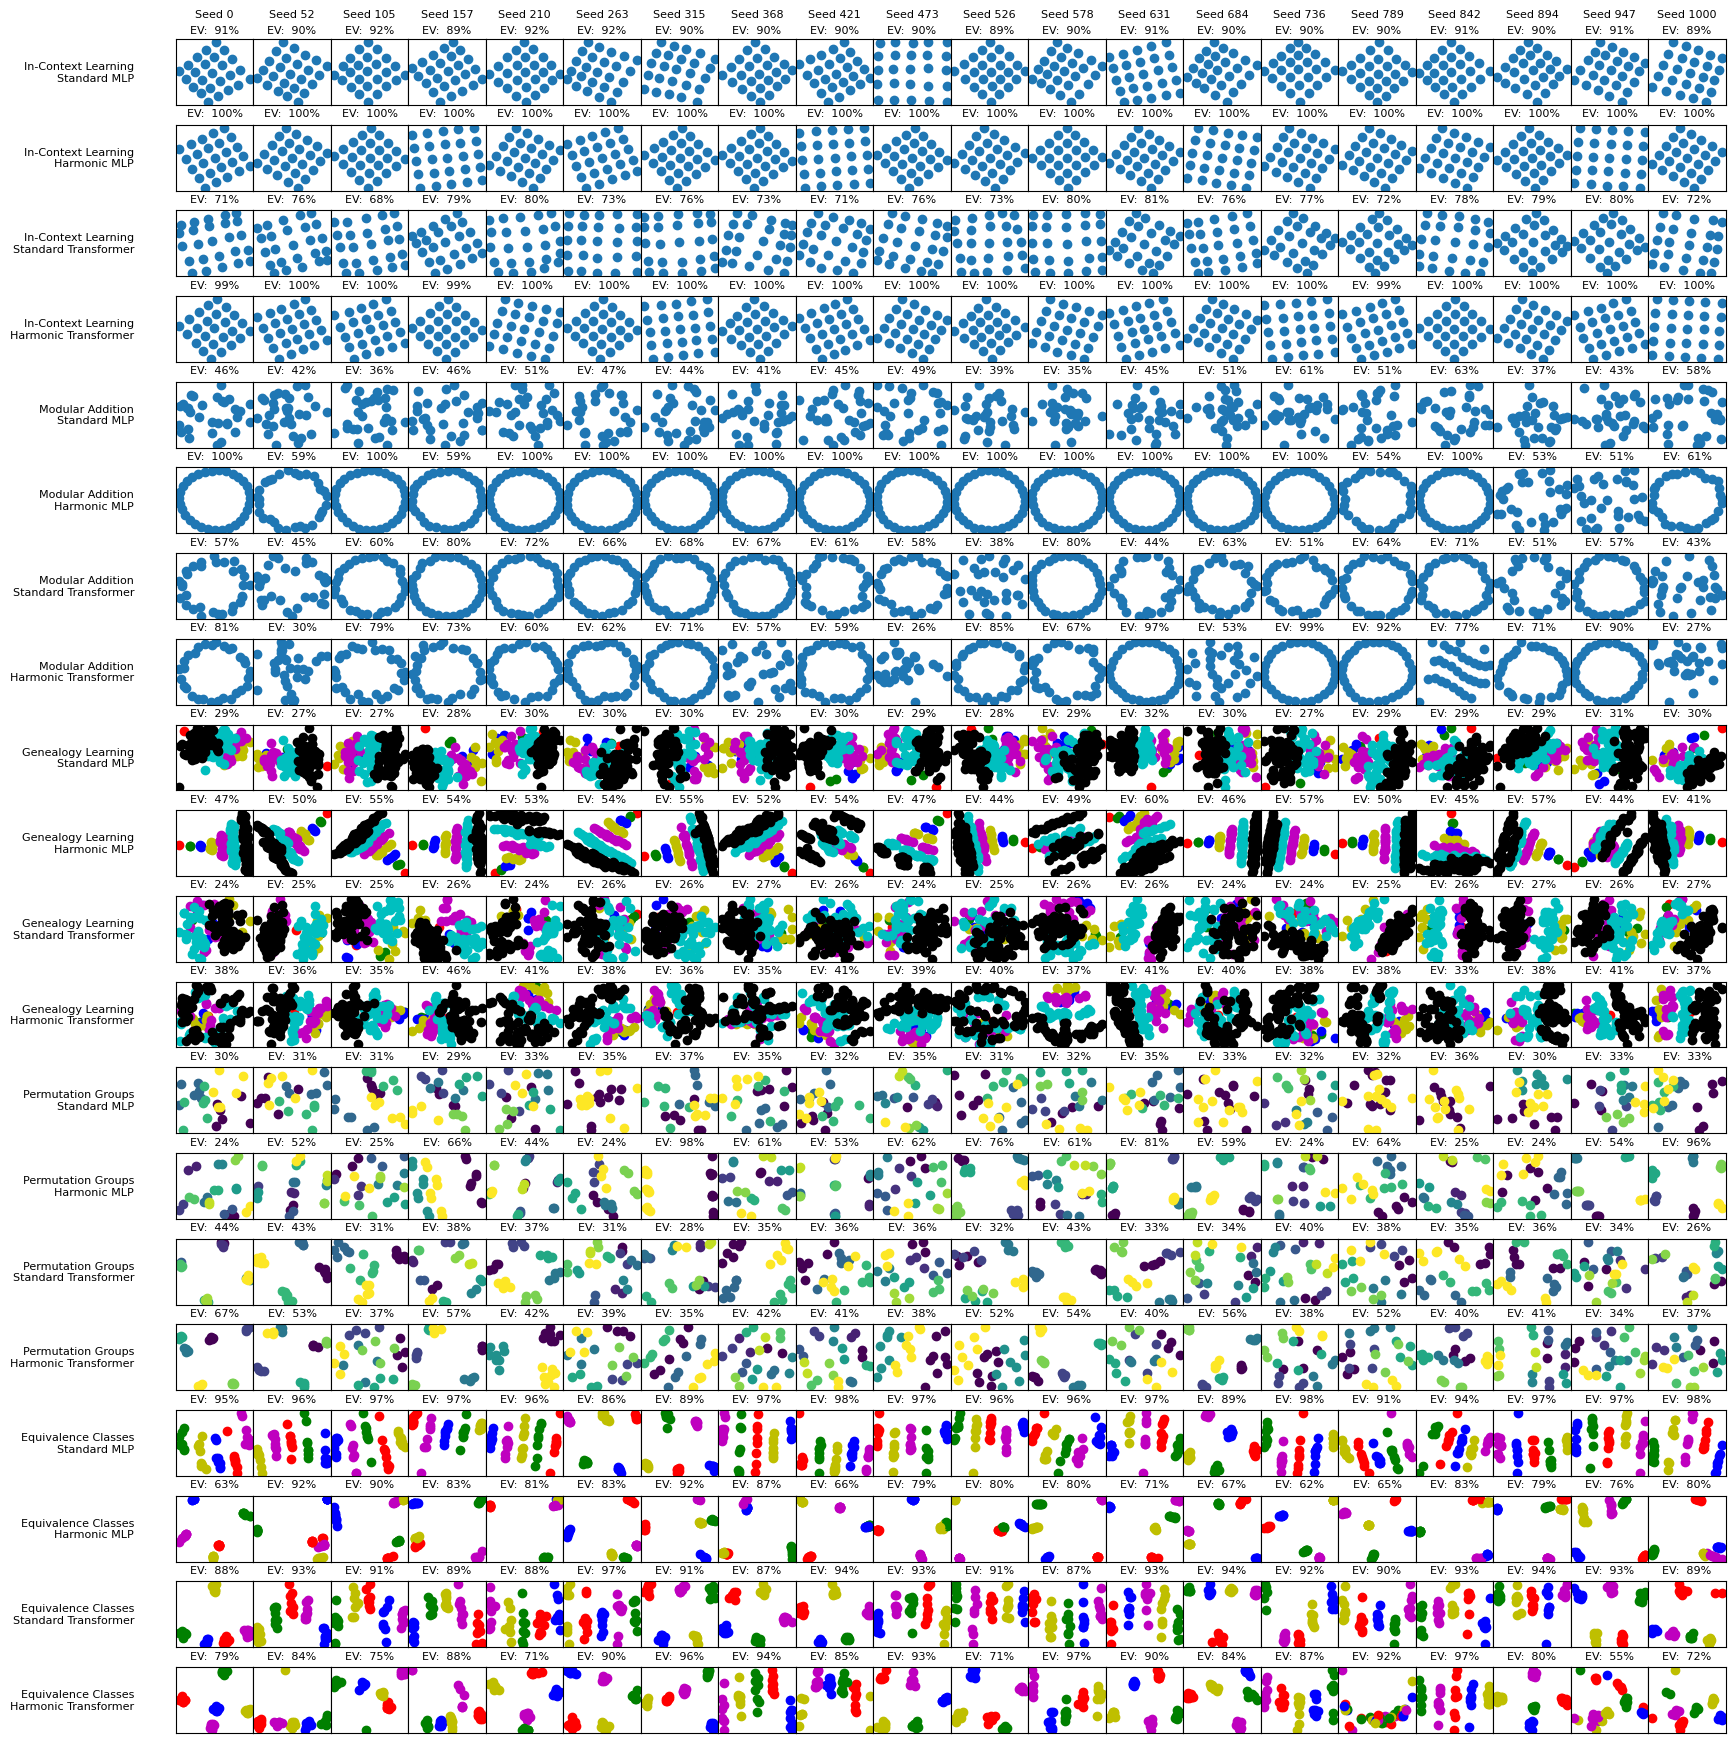

<Figure size 640x480 with 0 Axes>

In [10]:
# Create a 16x20 grid of subplots
fig, axes = plt.subplots(20, 20, figsize=(20, 22))

plt.subplots_adjust(wspace=0.0, hspace=0.3)

dict_level = dict()
dict_level[1] = 0
for i in range(1,127):
    if (2*i) < 127:
        dict_level[2*i] = dict_level[i] + 1
    if (2*i + 1) < 127:
        dict_level[2*i + 1] = dict_level[i] + 1

# Add labels for rows and columns
for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        plt.subplot(20, 20, i*20 + j + 1)
        
        # Remove ticks for clarity
        ax.set_xticks([])
        ax.set_yticks([])

        data_id = data_id_choices[i // 4]
        model_id = model_id_choices[i % 4]
        seed = seed_list[j]

        string_to_find = f"{data_id}-{model_id}"
        results_root = find_folders_with_string(path_to_search, string_to_find)

        weights = torch.load(f"{results_root}/{seed}_{data_id}_{model_id}_{data_size}_{train_ratio}_1.pt", map_location=torch.device('cpu'))
        if 'MLP' in model_id:
            emb = weights['embedding']
        else:
            emb = weights['embedding.weight']

        if "family" in data_id:
            emb = emb[1:127]
        if "equivalence" in data_id:
            emb = emb[:40]

        pca = PCA(n_components=2)
        pca_emb = pca.fit_transform(emb.cpu())
        if i != 0:
            ax.set_title(f'EV: {(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100: .0f}%',fontsize=8)
        else:
            ax.set_xlabel(f'EV: {(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100: .0f}%',fontsize=8)
            ax.xaxis.set_label_position('top')

        if "family" in data_id:
            for kk in range(1,127):
                ax.scatter(pca_emb[kk-1, 0], pca_emb[kk-1, 1], c=colors[dict_level[kk]])
        elif "equivalence" in data_id:
            for kk in range(40):
                ax.scatter(pca_emb[kk, 0], pca_emb[kk, 1], c=colors[kk%5])
        elif "permutation" in data_id:
            right_coset_list, left_coset_list = get_right_and_left_coset()
            visualize_best_embedding(emb, right_coset_list, left_coset_list)
        else:
            ax.scatter(pca_emb[:, 0], pca_emb[:, 1])

#        plt.axis('square')
        plt.axis('scaled')
        x_lim = plt.gca().get_xlim()
        y_lim = plt.gca().get_ylim()
        print(x_lim[1]-x_lim[0], y_lim[1] - y_lim[0])

        
        # Label the first column with row numbers
        if j == 0:
            ax.set_ylabel(f'{data_id_to_title_map[data_id]}\n{model_id_to_legend_map[model_id]}', rotation=0, labelpad=30, fontsize=8, ha='right', va='center')
        
        # Label the last row with column numbers
        if i == 0:
            ax.set_title(f'Seed {seed}', fontsize=8)
#            ax.xaxis.set_label_position('top')  # Place column labels at the top




# Show the plot
plt.show()
plt.savefig("../figures/rep_plots.pdf", bbox_inches='tight')


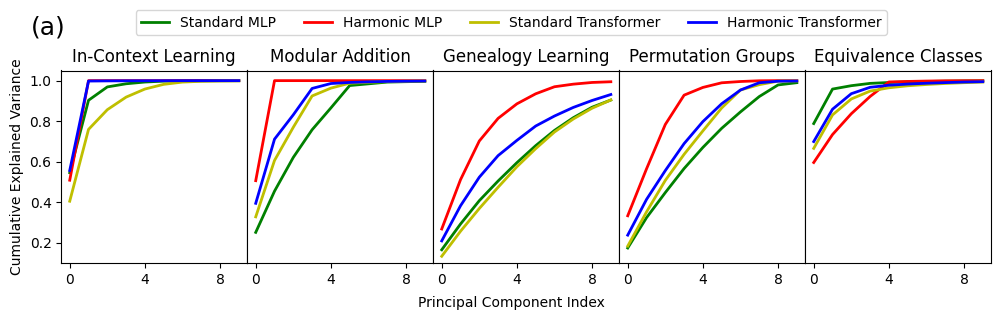

<Figure size 640x480 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt

# Create the figure
fig = plt.figure(figsize=(12, 2.5))

# Placeholder for the handles and labels for the legend
handles, labels = None, None
colors = ['g', 'r', 'y', 'b']

data_id_to_title_map = {
    'lattice': 'In-Context Learning',
    'family_tree': 'Genealogy Learning',
    'equivalence': 'Equivalence Classes',
    'circle': 'Modular Addition',
    'permutation' : 'Permutation Groups'
}

model_id_to_legend_map = {
    'standard_MLP': 'Standard MLP',
    'H_MLP': 'Harmonic MLP',
    'standard_transformer': 'Standard Transformer',
    'H_transformer': 'Harmonic Transformer'
}
train_ratio = 0.8
import json
# Plot subplots
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    data_id = data_id_choices[i]
    for j in range(len(model_id_choices)):
        model_id = model_id_choices[j]
        string_to_find = f"{data_id}-{model_id}"
        results_root = find_folders_with_string(path_to_search, string_to_find)
        all_metric_list = []
        for seed in seed_list:
            fname = f'{results_root}/{seed}_{data_id}_{model_id}_{data_size}_{train_ratio}_1.json'
            with open(fname, 'r') as file:
                data = json.load(file)
                metric_list = data['variances']

            metric_cumsum = np.cumsum(metric_list)
            all_metric_list.append(list(metric_cumsum))

        metric_cumsum = np.median(all_metric_list, axis=0)
        
        ax.plot(range(10), metric_cumsum[:10], label=model_id_to_legend_map[model_id_choices[j]], color=colors[j], linewidth=2)
    
    # Collect handles and labels from the first subplot only
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
    
    if i > 0:
        ax.set_yticks([])
    if i == 0:
        ax.set_ylabel("Cumulative Explained Variance")
#    ax.set_xticks(range(len(metric_list)))
    ax.set_xticks([0,4,8])
    ax.set_ylim([0.1,1.05])
    ax.set_title(f"{data_id_to_title_map[data_id]}", fontsize=12)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.0, hspace=0.3)

# Add shared xlabel
fig.text(0.5, -0.05, "Principal Component Index", ha="center", va="center")

# Add shared legend
fig.legend(
    handles=handles,
    labels=labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=4
)

fig.text(
    0.1, 1.1,  # Position relative to the figure
    "(a)", 
    fontsize=18, 
#    fontweight='bold', 
    verticalalignment='top'
)

plt.show()
plt.savefig('../figures/ev_plot.pdf', bbox_inches='tight')

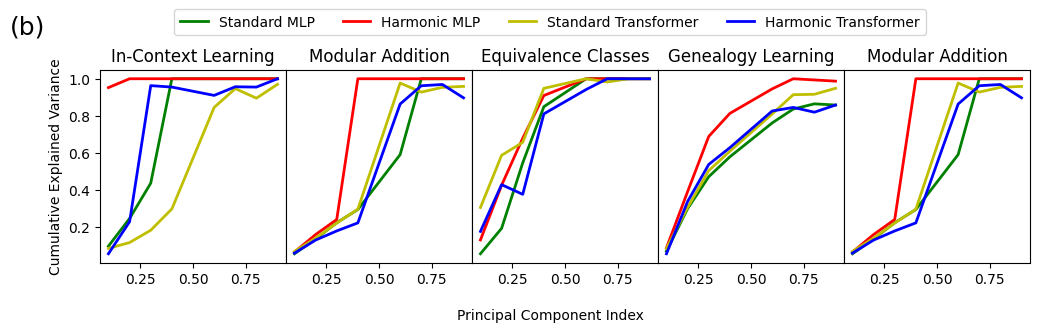

In [ ]:
import matplotlib.pyplot as plt

# Create the figure
fig = plt.figure(figsize=(12, 2.5))

# Placeholder for the handles and labels for the legend
handles, labels = None, None
colors = ['g', 'r', 'y', 'b']

data_id_to_title_map = {
    'lattice': 'In-Context Learning',
    'family_tree': 'Genealogy Learning',
    'equivalence': 'Equivalence Classes',
    'circle': 'Modular Addition',
    'permutation' : 'Permutation Groups'
}

model_id_to_legend_map = {
    'standard_MLP': 'Standard MLP',
    'H_MLP': 'Harmonic MLP',
    'standard_transformer': 'Standard Transformer',
    'H_transformer': 'Harmonic Transformer'
}
train_ratio_list = [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9]
seed = 66
import json
# Plot subplots
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    data_id = data_id_choices[i]
    for j in range(len(model_id_choices)):
        model_id = model_id_choices[j]
        string_to_find = f"{data_id}-{model_id}"
        results_root = find_folders_with_string(path_to_search, string_to_find)
        metric_list = []
        for train_ratio in train_ratio_list:
            fname = f'{results_root}/{seed}_{data_id}_{model_id}_{data_size}_{train_ratio}_1_train_results.json'
            with open(fname, 'r') as file:
                data = json.load(file)
                metric_list.append(data['test_accuracies'][-1])
        
        ax.plot(train_ratio_list, metric_list, label=model_id_to_legend_map[model_id_choices[j]], color=colors[j], linewidth=2)
    
    # Collect handles and labels from the first subplot only
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
    
    if i > 0:
        ax.set_yticks([])
    if i == 0:
        ax.set_ylabel("Test Accuracy")
    ax.set_title(f"{data_id_to_title_map[data_id]}", fontsize=12)
    ax.set_xticks([0,0.4,0.8])

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.0, hspace=0.3)

# Add shared xlabel
fig.text(0.5, -0.1, "Train Fraction", ha="center", va="center")

# Add shared legend
fig.legend(
    handles=handles,
    labels=labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=4
)

fig.text(
    0.05, 1.1,  # Position relative to the figure
    "(b)", 
    fontsize=18, 
#    fontweight='bold', 
    verticalalignment='top'
)

plt.show()
plt.savefig('../figures/ev_plot.pdf', bbox_inches='tight')

In [9]:
def find_consecutive_elements(arr, threshold=0.9, window_size=20):
    """Find starting index of consecutive elements above threshold"""
    for i in range(len(arr) - window_size + 1):
        if all(x > threshold for x in arr[i:i+window_size]):
            return i
    return -1

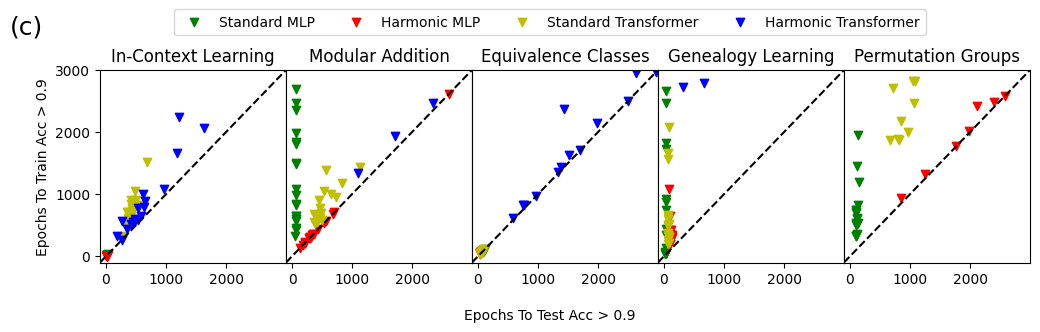

In [29]:
import matplotlib.pyplot as plt

data_id_choices = ["lattice", "circle", "equivalence", "family_tree", "permutation"]
# Create the figure
fig = plt.figure(figsize=(12, 2.5))

# Placeholder for the handles and labels for the legend
handles, labels = None, None
colors = ['g', 'r', 'y', 'b']

data_id_to_title_map = {
    'lattice': 'In-Context Learning',
    'family_tree': 'Genealogy Learning',
    'equivalence': 'Equivalence Classes',
    'circle': 'Modular Addition',
    'permutation' : 'Permutation Groups'
}
model_id_choices = ["standard_MLP","H_MLP", "standard_transformer","H_transformer"]
model_id_to_legend_map = {
    'standard_MLP': 'Standard MLP',
    'H_MLP': 'Harmonic MLP',
    'standard_transformer': 'Standard Transformer',
    'H_transformer': 'Harmonic Transformer'
}

seed = 66
train_ratio = 0.8
import json
# Plot subplots
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    data_id = data_id_choices[i]
    max_idx = 0
    for j in range(len(model_id_choices)):
        model_id = model_id_choices[j]
        string_to_find = f"{data_id}-{model_id}"
        results_root = find_folders_with_string(path_to_search, string_to_find)
        idx_train_list = []
        idx_test_list = []
        for seed in seed_list:
            fname = f'{results_root}/{seed}_{data_id}_{model_id}_{data_size}_{train_ratio}_1_train_results.json'
            with open(fname, 'r') as file:
                data = json.load(file)
                idx_train = find_consecutive_elements(np.array(data['train_accuracies']))
                idx_test = find_consecutive_elements(np.array(data['test_accuracies']))
                
                if idx_train == -1 or idx_test == -1:
                    continue
                idx_train_list.append(idx_train)
                idx_test_list.append(idx_test)
                if idx_train > max_idx:
                    max_idx = idx_train
                if idx_test > max_idx:
                    max_idx = idx_test
                
        ax.scatter(idx_train_list, idx_test_list, marker='v', label=model_id_to_legend_map[model_id_choices[j]], color=colors[j])

    
    # Collect handles and labels from the first subplot only
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
    
    if i > 0:
        ax.set_yticks([])
    if i == 0:
        ax.set_ylabel("Epochs To Train Acc > 0.9")
    ax.set_title(f"{data_id_to_title_map[data_id]}", fontsize=12)
    max_idx = 3000
    ax.plot([-100,max_idx], [-100,max_idx], 'k--')
    ax.set_xlim([-100,max_idx])
    ax.set_ylim([-100,max_idx])
    ax.set_xticks([0, 1000, 2000])
    

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.0, hspace=0.3)

# Add shared xlabel
fig.text(0.5, -0.1, "Epochs To Test Acc > 0.9", ha="center", va="center")

# Add shared legend
fig.legend(
    handles=handles,
    labels=labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=4
)

fig.text(
    0.05, 1.1,  # Position relative to the figure
    "(c)", 
    fontsize=18, 
#    fontweight='bold', 
    verticalalignment='top'
)

plt.show()
plt.savefig('../results/grokking_plot.pdf', bbox_inches='tight')
